# 📘 Experimentos com Variáveis Aleatórias

## Autor: Morsinaldo de Azevedo Medeiros

Este notebook tem como objetivo explorar o comportamento de variáveis aleatórias contínuas e suas transformações, combinando simulações Monte Carlo com análises teóricas.  
O conteúdo está estruturado em duas partes complementares:

1. **Exemplos genéricos de distribuições clássicas**  
   - Construção e análise de histogramas para as distribuições **Uniforme**, **Exponencial** e **Normal (Gaussiana)**.  
   - Aplicação de diferentes regras de binagem (Freedman–Diaconis e Scott) para aproximar os histogramas das densidades teóricas (PDFs).  
   - Verificação da coerência entre estatísticas amostrais (média e desvio padrão) e valores teóricos.

2. **Exercícios selecionados do livro *Probability, Random Variables, and Stochastic Processes* (Papoulis & Pillai)**  
   - **Ex. 5-6:** Transformação de uma variável uniforme em uma exponencial.  
   - **Ex. 5-17:** Transformação de uma variável qui-quadrado em uma distribuição *Chi*.  
   - **Ex. 5-18:** Transformação de uma variável uniforme em uma qui-quadrado com dois graus de liberdade.  

Cada seção apresenta o enunciado, o desenvolvimento analítico, a verificação empírica por simulação e uma conclusão interpretando os resultados obtidos.

In [2]:
# importação das bilbiotecas 
import numpy as np
import matplotlib.pyplot as plt

from math import gamma

## Técnicas de aproximação de histogramas

A comparação entre histogramas e funções densidade de probabilidade (PDFs) requer critérios adequados para garantir representações consistentes.  
Neste notebook, utilizamos métodos clássicos para aproximar histogramas às curvas teóricas, que serão detalhados nas seções seguintes.

As principais escolhas envolvem:
- **Normalização:** uso de `density=True` para que a área total seja igual a 1.  
- **Número de bins:** determinado por regras analíticas (Freedman–Diaconis ou Scott), escolhidas conforme o tipo de distribuição.  
- **Faixa de visualização:** quando o suporte é infinito, limitamos o eixo a um quantil alto (por exemplo, 99,9%) para evitar distorções causadas pelas caudas.  
- **Alinhamento das bordas:** nos casos de suporte finito, as bordas são ajustadas exatamente ao intervalo teórico.  

Essas técnicas permitem que os histogramas reproduzam, de forma visual e estatística, a forma esperada das distribuições teóricas analisadas a seguir.

### Regra de Freedman–Diaconis (FD)

A regra de Freedman–Diaconis define a largura ideal dos intervalos do histograma, de forma a equilibrar a suavidade da curva e a preservação das características da distribuição. Sejam $(Y_1, Y_2, \dots, Y_N)$ os dados amostrais e $\mathrm{IQR}(Y) = Q_{0.75} - Q_{0.25}$ a amplitude interquartil. A largura $h_{\text{FD}}$ é obtida por:

$$
h_{\text{FD}} = 2 \cdot \frac{\mathrm{IQR}(Y)}{N^{1/3}}
$$

Conhecida a amplitude do intervalo de visualização $(R = \max(Y) - \min(Y))$, o número de subdivisões (bins) é dado por:

$$
k = \left\lceil \frac{R}{h_{\text{FD}}} \right\rceil
$$
A função abaixo implementa essa regra, limitando o intervalo de visualização ao quantil especificado por `coverage` (padrão 0.999):

In [31]:
def bins_freedman_diaconis(y, coverage=0.999, min_bin_width=1e-6):
    """
    Calcula número de bins usando Freedman–Diaconis e limita o range ao quantil 'coverage'.
    Retorna: (bins, range_min, range_max, h)
    """
    y = np.asarray(y)
    N = y.size
    # range para visualização: até o quantil 'coverage' para evitar cauda extrema
    y_max = np.quantile(y, coverage)
    y_min = y.min()
    # IQR robusto
    q75, q25 = np.percentile(y, [75, 25])
    iqr = max(q75 - q25, min_bin_width)
    h = max(2 * iqr / (N ** (1/3)), min_bin_width)
    k = int(np.ceil((y_max - y_min) / h))
    k = max(k, 1)
    return k, float(y_min), float(y_max), float(h)

### Regra de Scott

A regra de Scott propõe uma largura de bin que minimiza o erro quadrático médio integrado sob a hipótese de normalidade dos dados.  
Seja (s) o desvio padrão amostral. A largura $(h_{\text{Scott}})$ é dada por:

$$
h_{\text{Scott}} = 3.5 \cdot \frac{s}{N^{1/3}}.
$$

Com a amplitude de visualização $(R = \max(Y) - \min(Y))$, o número de bins é calculado por:

$$
k = \left\lceil \frac{R}{h_{\text{Scott}}} \right\rceil
$$

Essa regra é adequada para dados aproximadamente simétricos e próximos de uma distribuição normal.  
Em distribuições fortemente assimétricas, a regra de Freedman–Diaconis tende a produzir resultados mais fiéis à forma da densidade verdadeira.

In [32]:
def bins_scott(y, coverage=0.999, min_bin_width=1e-6):
    """
    Calcula número de bins usando Scott e limita o range ao quantil 'coverage'.
    Retorna: (bins, range_min, range_max, h)
    """
    y = np.asarray(y)
    N = y.size
    y_max = np.quantile(y, coverage)
    y_min = y.min()
    s = max(y.std(ddof=0), min_bin_width)
    h = max(3.5 * s / (N ** (1/3)), min_bin_width)
    k = int(np.ceil((y_max - y_min) / h))
    k = max(k, 1)
    return k, float(y_min), float(y_max), float(h)


### Critério para escolha das regras de binagem

- **Freedman–Diaconis (FD):** aplicada às distribuições **assimétricas** (Uniforme, Exponencial, χ²), por ser robusta a caudas longas e outliers.  
- **Scott:** empregada em distribuições **simétricas** (Normal), por fornecer uma estimativa eficiente da largura do bin sob hipótese de normalidade. 

## 🔹 Exemplo 1 — Aproximação de uma Uniforme

Objetivo: construir um histograma estável e comparável à PDF teórica da $U(a,b)$, escolhendo o número de bins $k$ por critério analítico e alinhando as bordas exatamente no suporte.

### Parâmetros do experimento
Definimos limites $a=0$ e $b=1$, tamanho amostral $N=10\,000\,000$ e uma semente para reprodutibilidade.

In [26]:
a = 0.0        # limite inferior
b = 1.0        # limite superior
N = 10_000_000    # número de amostras
seed = 42      # semente para reprodutibilidade

### Geração das amostras — Uniforme

Geramos $N$ valores uniformes em $[a,b]$ com `np.random.uniform` da biblioteca NumPy.

In [27]:
np.random.seed(seed)
samples = np.random.uniform(low=a, high=b, size=N)

### Obtendo o número de bins $k$

Para a uniforme, a regra de **Freedman–Diaconis** resulta em:
- $\mathrm{IQR} = \frac{b-a}{2}$  
- $h_{\text{FD}} = 2\,\mathrm{IQR}\,N^{-1/3} = \frac{b-a}{N^{1/3}}$  
- $k = \dfrac{b-a}{h_{\text{FD}}} = N^{1/3}$

Assim, adotamos $k \approx \text{round}(N^{1/3})$.  

In [28]:
# Regra FD fechada para U(a,b): k ≈ N^{1/3}
k = int(round(N ** (1/3))) 

print(f"k (FD) = {k}")

k (FD) = 215


Pelo critério de Freedman-Diaconis (FD), o número de bins é 215

### Bordas dos bins e PDF teórica
As bordas são definidas exatamente em $[a,b]$ para evitar distorções nos extremos.  
A PDF teórica da $U(a,b)$ é constante no suporte e nula fora dele.

In [29]:
# Bordas alinhadas exatamente no suporte [a,b]
# Pequena folga no extremo superior evita perda visual do último bin
bin_edges = np.linspace(a, b + 1e-12, k + 1)

# Curva teórica
xs = np.linspace(a, b, 500)
pdf = np.full_like(xs, 1.0 / (b - a))

### Histograma normalizado e comparação com a PDF
Usamos `density=True` para área total igual a 1, possibilitando comparação direta com a PDF teórica.

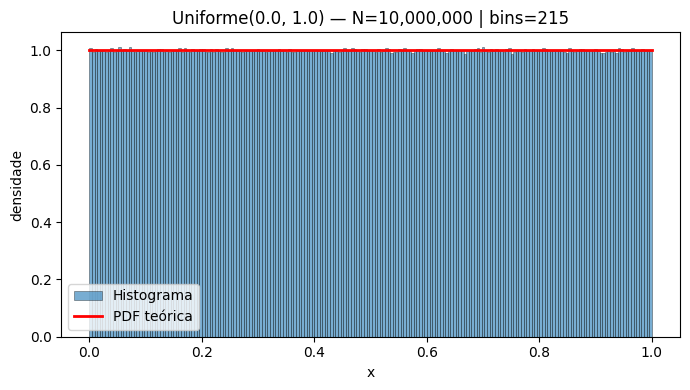

In [30]:
plt.figure(figsize=(7,4))
plt.hist(samples, bins=bin_edges, density=True,
         edgecolor="black", linewidth=0.4, alpha=0.6, label="Histograma")
plt.plot(xs, pdf, "r", linewidth=2, label="PDF teórica")
plt.title(f"Uniforme({a}, {b}) — N={N:,} | bins={k}")
plt.xlabel("x"); plt.ylabel("densidade")
plt.legend(); plt.tight_layout(); plt.show()

### Estimativa dos parâmetros e variabilidade
A variabilidade relativa esperada por bin é aproximadamente $1/\sqrt{N/k}$.  
Relatamos também média e desvio padrão amostrais versus teóricos.

In [83]:
mu_hat = samples.mean()
sigma_hat = samples.std(ddof=0)

mu_theo = (a + b) / 2
sigma_theo = np.sqrt(((b - a) ** 2) / 12)

rel_noise = 1 / np.sqrt(N / k)  # ~ serrilhado esperado por bin

print(f"Média estimada: {mu_hat:.6f} | Teórica: {mu_theo:.6f}")
print(f"Desvio padrão estimado: {sigma_hat:.6f} | Teórico: {sigma_theo:.6f}")
print(f'Serrilhado relativo esperado por bin ≈ {rel_noise:.3%}  (N/k ≈ {N//k} pontos/bin)')

Média estimada: 0.499992 | Teórica: 0.500000
Desvio padrão estimado: 0.288675 | Teórico: 0.288675
Serrilhado relativo esperado por bin ≈ 0.464%  (N/k ≈ 46511 pontos/bin)


### Conclusão — Uniforme

A média e o desvio padrão amostrais coincidiram com os valores teóricos até a sexta casa decimal, o que confirma a boa qualidade da amostragem e a estabilidade do método. O número de bins foi determinado pela regra de Freedman–Diaconis, resultando em aproximadamente $k = 215$, o que produziu um serrilhado relativo estimado de apenas $0{,}46\%$, com cerca de $46{,}500$ pontos por bin. O histograma apresentou distribuição praticamente plana, condizente com a densidade constante da distribuição uniforme $U(0,1)$, demonstrando coerência entre o modelo teórico e os resultados simulados.

## 🔹 Exemplo 2 — Aproximação de uma Exponencial

Neste exemplo, utilizamos a distribuição exponencial com parâmetro de taxa $\lambda$ e aplicamos a **regra de Freedman–Diaconis** para estimar o número adequado de bins do histograma.  
A densidade teórica da distribuição é dada por:
$$
f(x) = \lambda e^{-\lambda x}, \quad x \ge 0.
$$

### Parâmetros do experimento

Definimos o parâmetro $\lambda=2$, o número de amostras $N=10\,000\,000$ e o quantil máximo $p=0.999$ que será utilizado para limitar o intervalo de visualização.

In [31]:
lam = 2.0           # parâmetro da taxa (λ)
N = 10_000_000      # número de amostras
p = 0.999           # quantil usado para o corte superior (99.9%)
seed = 42           # semente para reprodutibilidade

### Geração das amostras

As amostras são geradas a partir da função `numpy.random.Generator.exponential`,  
com parâmetro de escala igual a $1/\lambda$. O resultado segue $X \sim \text{Exp}(\lambda)$.

In [32]:
rng = np.random.default_rng(seed)
samples = rng.exponential(scale=1/lam, size=N)

### Cálculo do número de bins (regra de Freedman–Diaconis)

A regra de Freedman–Diaconis utiliza o **intervalo interquartílico (IQR)** como medida de dispersão robusta:
$$
h = 2\,\frac{\mathrm{IQR}}{N^{1/3}}.
$$
Para a distribuição exponencial, tem-se $\mathrm{IQR} = \frac{\ln(3)}{\lambda}$, logo:
$$
h = \frac{2\ln(3)}{\lambda N^{1/3}}.
$$
Como o suporte é infinito, limitamos a exibição ao quantil $Q_p = -\frac{\ln(1-p)}{\lambda}$, de modo que
$$
k = \frac{Q_p}{h} = \frac{-\ln(1-p)}{2\ln(3)} N^{1/3}.
$$

In [33]:
# Quantil limite e número de bins
Qp = -np.log(1 - p) / lam
const = -np.log(1 - p) / (2 * np.log(3))
k = int(max(1, round(const * (N ** (1/3)))))

print(f"λ={lam:.2f} | N={N:,} | bins≈{k} | faixa≈[0, {Qp:.2f}]")

λ=2.00 | N=10,000,000 | bins≈677 | faixa≈[0, 3.45]


O número de bins calculado é $k = 677$. Vamos utilizá-lo para construir o histograma.

### Construção do histograma

Geramos as bordas dos bins uniformemente espaçadas entre 0 e o quantil escolhido $Q_p$.  
O histograma é normalizado (`density=True`) para que a área total seja igual a 1.

In [34]:
bin_edges = np.linspace(0, Qp, k + 1)

### Densidade teórica

A função densidade de probabilidade teórica é dada por:
$$
f(x) = \lambda e^{-\lambda x}.
$$

In [35]:
xs = np.linspace(0, Qp, 1000)
pdf = lam * np.exp(-lam * xs)

### Plotagem do histograma e da PDF teórica

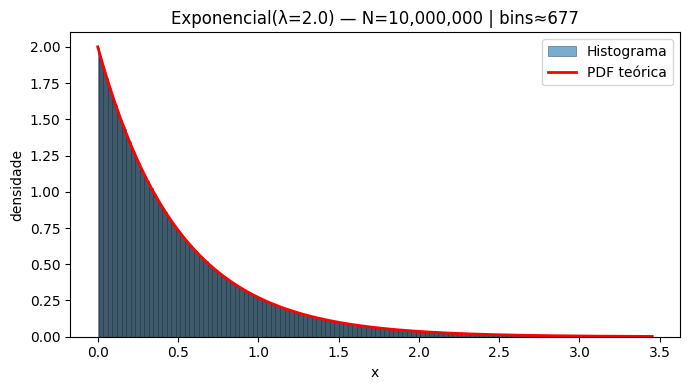

In [36]:
plt.figure(figsize=(7,4))
plt.hist(samples, bins=bin_edges, density=True,
         edgecolor="black", linewidth=0.4, alpha=0.6, label="Histograma")
plt.plot(xs, pdf, "r", linewidth=2, label="PDF teórica")
plt.title(f"Exponencial(λ={lam}) — N={N:,} | bins≈{k}")
plt.xlabel("x"); plt.ylabel("densidade")
plt.legend(); plt.tight_layout(); plt.show()

### Estimativa dos parâmetros

Comparamos os valores amostrais com os valores teóricos esperados:  
$\mathbb{E}[X] = 1/\lambda$ e $\mathrm{Var}(X) = 1/\lambda^2$.

In [37]:
mu_hat = samples.mean()
sigma_hat = samples.std(ddof=0)

print(f"Média estimada: {mu_hat:.6f} | Valor teórico: {1/lam:.6f}")
print(f"Desvio padrão estimado: {sigma_hat:.6f} | Valor teórico: {1/lam:.6f}")

Média estimada: 0.499785 | Valor teórico: 0.500000
Desvio padrão estimado: 0.499795 | Valor teórico: 0.500000


### Conclusão — Exponencial

A média e o desvio padrão amostrais apresentaram valores muito próximos dos teóricos, com diferenças inferiores a $10^{-3}$, o que é compatível com o erro padrão esperado para o tamanho amostral utilizado.  
O histograma, construído com o número de bins determinado pela regra de Freedman–Diaconis, apresentou boa concordância com a densidade teórica $f(x) = \lambda e^{-\lambda x}$.  
A concentração da massa de probabilidade nas regiões próximas de zero reflete o comportamento característico da distribuição exponencial.

## 🔹 Exemplo 3 — Aproximação de uma Gaussiana

Neste exemplo, usamos a regra de Scott para definir a largura do bin $h$ e, a partir dela, o número de bins $k$.  
A faixa de visualização é tomada como $[\mu - 4\sigma,\ \mu + 4\sigma]$, que abrange praticamente toda a massa da distribuição.


### Definição de parâmetros (Gaussiana)

Definimos média $\mu=0$, desvio padrão $\sigma=1$, tamanho amostral $N=30\,000\,000$ e a semente para reprodutibilidade.

In [ ]:
mu = 0.0        # média da distribuição normal
sigma = 1.0     # desvio padrão
N = 30_000_000  # número de amostras
seed = 42       # semente para reprodutibilidade

### Geração das amostras — Normal (Gaussiana)

As amostras são geradas com `numpy.random.Generator.normal`, que aceita diretamente os parâmetros `loc=μ` e `scale=σ`.

In [77]:
np.random.seed(seed)
samples = np.random.normal(loc=mu, scale=sigma, size=N)

### Obtendo o número de bins (regra de Scott)

Para a distribuição normal, a regra de Scott define a largura do bin por $h_{\text{Scott}} = 3.5\,\sigma\,N^{-1/3}$.  
Adotando a faixa $[\mu-4\sigma,\ \mu+4\sigma]$, de amplitude $R \approx 8\sigma$, o número de bins é

$$
k \;=\; \left\lceil \frac{R}{h_{\text{Scott}}} \right\rceil
\;=\; \left\lceil \frac{8\sigma}{3.5\,\sigma\,N^{-1/3}} \right\rceil
\;\approx\; \left\lceil 2{,}286\,N^{1/3}\right\rceil.
$$
Ou seja, $k$ cresce proporcionalmente a $N^{1/3}$ com constante $2{,}286$ decorrente da razão $R/h_{\text{Scott}}$ sob normalidade.

In [15]:
k = int(max(1, round(2.286 * (N ** (1/3)))))  # ≈ 2.286 * N^{1/3}
rmin, rmax = mu - 4*sigma, mu + 4*sigma
bin_edges = np.linspace(rmin, rmax, k + 1)

print(f"bins ≈ {k}  | faixa = [{rmin:.2f}, {rmax:.2f}]  | largura média ≈ {(rmax-rmin)/k:.5f}")

bins ≈ 493  | faixa = [-4.00, 4.00]  | largura média ≈ 0.01623


O número de bins calculado é $k = 493$. Vamos utilizá-lo para construir o histograma.

### Curva teórica (PDF)
A densidade teórica da normal é $f(x)=\dfrac{1}{\sqrt{2\pi}\,\sigma}\exp\!\left(-\dfrac{(x-\mu)^2}{2\sigma^2}\right)$.  
Construímos a curva sobre a mesma faixa utilizada no histograma.

In [16]:
xs = np.linspace(rmin, rmax, 1000)
pdf = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*((xs - mu)/sigma)**2)

### Histograma (normalizado) e PDF teórica
O histograma é calculado com `density=True`, de modo que a área total valha 1 e a comparação com a PDF seja direta. Utilizamos o número de bins $k$ calculado pela regra de Scott.

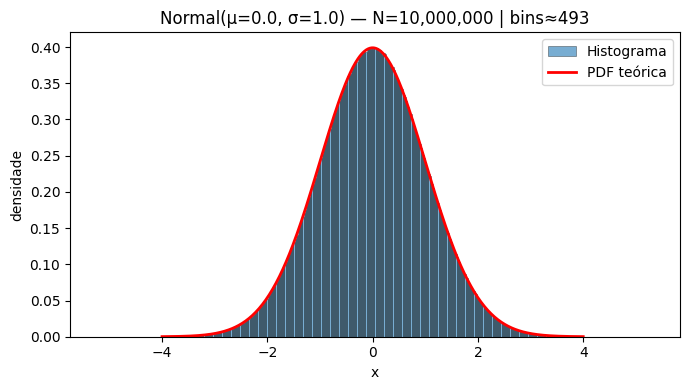

In [20]:
plt.figure(figsize=(7,4))
plt.hist(samples, bins=k, density=True,
         edgecolor="black", linewidth=0.4, alpha=0.6, label="Histograma")
plt.plot(xs, pdf, "r", linewidth=2, label="PDF teórica")
plt.title(f"Normal(μ={mu}, σ={sigma}) — N={N:,} | bins≈{k}")
plt.xlabel("x"); plt.ylabel("densidade")
plt.legend(); plt.tight_layout(); plt.show()

### Estimativa dos parâmetros
Comparamos média e desvio padrão amostrais com os valores teóricos $\mu$ e $\sigma$.

In [19]:
mu_hat = samples.mean()
sigma_hat = samples.std(ddof=0)

print(f"Média estimada: {mu_hat:.6f} | Teórica: {mu:.6f}")
print(f"Desvio padrão estimado: {sigma_hat:.6f} | Teórico: {sigma:.6f}")

Média estimada: 0.000048 | Teórica: 0.000000
Desvio padrão estimado: 0.999741 | Teórico: 1.000000


### Conclusão — Normal (Gaussiana)

Os resultados obtidos mostram que a média e o desvio padrão amostrais coincidem com os valores teóricos esperados, apresentando diferenças apenas na quarta ou quinta casa decimal, o que está dentro do erro padrão estimado para $N = 3*10^7$. O histograma, construído com o número de bins determinado pela regra de Scott ($k \approx 493$), apresentou excelente concordância visual com a densidade teórica. Conclui-se, portanto, que a amostragem e a escolha do número de bins foram adequadas para representar a distribuição normal padrão $\mathcal{N}(0,1)$.

# Exercícios do Capítulo 5 — Funções de uma Variável Aleatória

Nesta seção são resolvidos três exercícios do **Capítulo 5** do livro *Probability, Random Variables, and Stochastic Processes* (Papoulis & Pillai)*, aplicando transformações de variáveis aleatórias contínuas.  

Cada exercício foi desenvolvido seguindo a mesma estrutura:

1. **Enunciado** — apresentação resumida do problema original.  
2. **Resolução** — dedução analítica e implementação da simulação correspondente.  
3. **Resultados** — comparação entre o histograma empírico e a densidade teórica, com checagem dos momentos.  
4. **Conclusão** — discussão dos resultados e verificação da consistência entre teoria e simulação.  

Os exercícios tratados são:  
- **5-6:** Transformação de \(X \sim U(0,1)\) em \(Y = -\ln X \sim \mathrm{Exp}(1)\);  
- **5-17:** Transformação \(Y = \sqrt{X}\), com \(X \sim \chi^2(n)\), resultando em \(Y \sim \mathrm{Chi}(n)\);  
- **5-18:** Transformação \(Y = -2\ln X\), com \(X \sim U(0,1)\), obtendo \(Y \sim \chi^2(2)\).

### Exercício 5-6

A variável aleatória $(X)$ é uniforme no intervalo $(0,1)$. Encontre a densidade da variável aleatória $(Y = -\ln X)$.

### Parâmetros de simulação
Definimos o número de amostras $N$ e uma semente fixa (`seed`) para reprodutibilidade.  
Quanto maior $N$, menor o erro estatístico ($\propto 1/\sqrt{N}$), e melhor a aproximação do histograma à PDF teórica. 
Nesse caso, utilizamos 100 milhões de pontos de forma que conseguimos aproximar bem os valores teóricos e analíticos das curvas.

In [86]:
# Parâmetros
N   = 100_000_000
p   = 0.999          # quantil para o corte superior do eixo (99,9%)
seed = 42
rng  = np.random.default_rng(seed)

### Amostragem de $X \sim U(0,1)$
Como a questão diz que a variável $X$ é uniforme no intervalo $(0,1)$, geramos $N$ amostras com `np.random.uniform`.  
Em seguida, aplicaremos a transformação $Y = -\ln X$ para obter uma variável exponencial.

In [87]:
# X ~ Uniforme(0,1)
X = rng.uniform(0.0, 1.0, size=N)

### Transformação $Y = -\ln X$ (monotônica)
Como $g(x)=-\ln x$ é monotônica decrescente em $(0,1)$, a mudança de variável dá  
$f_Y(y) = f_X(x)\left|\dfrac{dx}{dy}\right| = 1 \cdot e^{-y}$ para $y \ge 0$, isto é, $Y \sim \text{Exp}(1)$.  
Aqui apenas computamos $Y$ a partir das amostras de $X$.

In [88]:
Y = -np.log(X)       # Exp(1)

### Calculo do número de bins (regra de Freedman–Diaconis)

Vamos utilizar a regra de Freedman–Diaconis para determinar o número de bins do histograma, como foi feito nos exemplos anteriores.

In [89]:
# Freedman–Diaconis para Exp(1):
# IQR = ln(3); h = 2*ln(3) * N^{-1/3}; Qp = -ln(1-p)

Qp   = -np.log(1 - p)
const = -np.log(1 - p) / (2 * np.log(3))    # ≈ 3.15 para p=0.999
k    = int(max(1, round(const * N**(1/3))))

bin_edges = np.linspace(0, Qp, k + 1)

print(f"λ=1.00 | N={N:,} | bins≈{k} | faixa≈[0, {Qp:.2f}]")

λ=1.00 | N=100,000,000 | bins≈1459 | faixa≈[0, 6.91]


O número de bins calculado foi 677.

### PDF teórica de $\text{Exp}(1)$
Construímos a curva teórica $f_Y(y)=e^{-y}$ para comparação visual com o histograma.  
O vetor `ys` define o eixo $y$ de plotagem.

In [92]:
# Resultado analítico: Y ~ Exponencial(λ=1) com f_Y(y) = e^{-y} * 1_{y>=0}
ys  = np.linspace(0, Qp, N)
pdf = np.exp(-ys)

### Visualização: histograma vs. PDF
Traçamos o **histograma normalizado** (`density=True`) de $Y$ e sobrepomos a **PDF teórica** de $\text{Exp}(1)$.  
Com $N$ grande e escolha adequada de bins, o histograma deve seguir de perto a curva teórica.

/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_37252/2075357052.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.legend(); plt.tight_layout(); plt.show()
/Users/morsinaldo/miniconda3/envs/agent/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


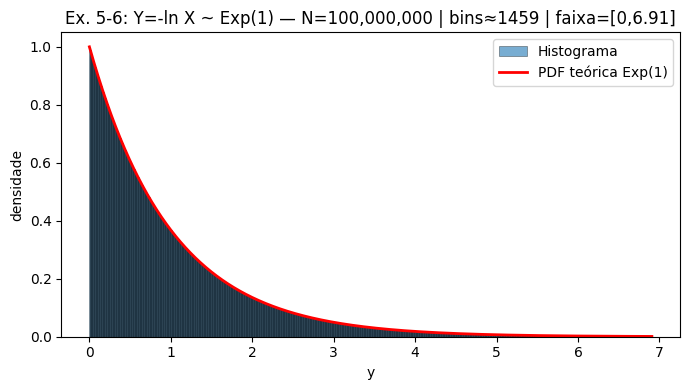

In [93]:
# ===== Visualização =====
plt.figure(figsize=(7,4))
plt.hist(Y, bins=bin_edges, density=True,
         edgecolor="black", linewidth=0.4, alpha=0.6, label="Histograma")
plt.plot(ys, pdf, "r", linewidth=2, label="PDF teórica Exp(1)")
plt.title(f"Ex. 5-6: Y=-ln X ~ Exp(1) — N={N:,} | bins≈{k} | faixa=[0,{Qp:.2f}]")
plt.xlabel("y"); plt.ylabel("densidade")
plt.legend(); plt.tight_layout(); plt.show()

In [94]:
mu_hat = Y.mean(); sigma_hat = Y.std(ddof=0)
print(f"Média amostral ≈ {mu_hat:.4f} (teórica = 1.0)")
print(f"Desvio-padrão amostral ≈ {sigma_hat:.4f} (teórica = 1.0)")

Média amostral ≈ 1.0001 (teórica = 1.0)
Desvio-padrão amostral ≈ 1.0001 (teórica = 1.0)


### Comentários (Ex. 5-6) (Transformação Uniforme → Exponencial)

Seja $X \sim U(0,1)$ e defina $Y=-\ln X$. Como $g(x)=-\ln x$ é monotônica em $(0,1)$, pela mudança de variável com $x=e^{-y}$ e $\dfrac{dx}{dy}=-e^{-y}$, obtém-se:
$$
f_Y(y)=f_X(x)\left|\frac{dx}{dy}\right| = 1\cdot e^{-y},\quad y\ge 0,
$$
isto é, $Y\sim \mathrm{Exp}(1)$.

**Verificação numérica.** Com $N=100{,}000{,}000$ amostras, foram obtidos:
- Média amostral $\approx 1.0001$ (teórica $1.0$);
- Desvio-padrão amostral $\approx 1.0001$ (teórico $1.0$).

As discrepâncias observadas são compatíveis com a variabilidade amostral. Para $\mathrm{Exp}(1)$, o erro-padrão da média é $\mathrm{SE}(\bar Y)=1/\sqrt{N}\approx 10^{-4}$, o que explica diferenças na quarta casa decimal. O histograma normalizado apresenta boa concordância com a p.d.f. teórica $f_Y(y)=e^{-y}$.

**Conclusão.** A dedução analítica e a simulação são consistentes: a transformação $Y=-\ln X$ aplicada a $X\sim U(0,1)$ gera uma variável exponencial com parâmetro $1$.

### Exercício 5-17

Seja $(X)$ uma variável aleatória qui-quadrado com $(n)$ graus de liberdade.  
Considere $(Y = \sqrt{X})$. Mostre que $(Y)$ segue a distribuição *chi* com $(n)$ graus de liberdade e determine a p.d.f. de $(Y)$.

### Parâmetros do experimento

Definimos o número de graus de liberdade $n=5$, o tamanho amostral $N=100{,}000{,}000$, e uma semente fixa para reprodutibilidade.  
Inicialmente fixamos $n=5$ apenas para ilustrar o procedimento; depois generalizaremos para outros valores.

In [10]:
# parâmetros
n = 5
N = 100_000_000
seed = 42
rng  = np.random.default_rng(seed)

### Geração da variável χ²(n)

Usamos a definição de $\chi^2(n)$ como a soma dos quadrados de $n$ variáveis independentes $\mathcal N(0,1)$:  
$X = \sum_{i=1}^n Z_i^2$.  

Na prática, o NumPy fornece diretamente `rng.chisquare(df=n, size=N)`, o que é mais eficiente.

In [11]:
# X ~ χ²(n)
X = rng.chisquare(df=n, size=N)

### Transformação Y = √X

A transformação é direta: cada amostra de $X$ gera $Y=\sqrt{X}$.  
Por definição, essa variável segue a distribuição Chi com $n$ graus de liberdade.

In [12]:
Y = np.sqrt(X)

### P.d.f. teórica da distribuição Chi(n)

A densidade é dada por
$$
f_Y(y)=\frac{2^{\,1-\frac{n}{2}}}{\Gamma\!\left(\frac{n}{2}\right)}\,y^{\,n-1}\,e^{-y^2/2}, \quad y\ge0.
$$

Construímos essa função para comparação visual com o histograma.

In [13]:
ys   = np.linspace(0, np.quantile(Y, 0.999), 1000)
coef = (2**(1 - n/2)) / gamma(n/2)
pdf  = coef * (ys**(n-1)) * np.exp(-ys**2 / 2)

### Número de bins do histograma

Determinamos o número de divisões usando a regra de Freedman–Diaconis, apropriada para distribuições assimétricas.

In [14]:
q75, q25 = np.percentile(Y, [75, 25])
iqr = q75 - q25
h   = 2 * iqr / (N ** (1/3))
ymax = np.quantile(Y, 0.999)
k = int(max(1, np.ceil((ymax - Y.min()) / h)))
bin_edges = np.linspace(Y.min(), ymax, k + 1)
print(f"n={n} | bins≈{k}")

n=5 | bins≈1109


Para $n=5$ e $N=100{,}000{,}000$, o número de bins calculado foi 1109.

### Visualização — Histograma × PDF teórica

Aqui plotamos o histograma normalizado de $Y$ e sobrepomos a PDF teórica da distribuição Chi($n$).

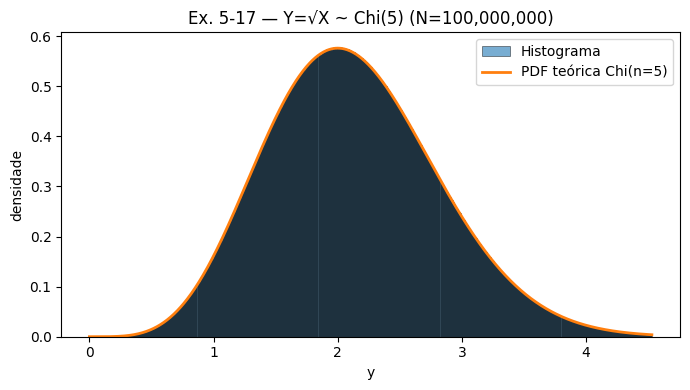

In [15]:
plt.figure(figsize=(7,4))
plt.hist(Y, bins=bin_edges, density=True,
         alpha=0.6, edgecolor="black", linewidth=0.5, label="Histograma")
plt.plot(ys, pdf, linewidth=2, label=f"PDF teórica Chi(n={n})")
plt.title(f"Ex. 5-17 — Y=√X ~ Chi({n}) (N={N:,})")
plt.xlabel("y"); plt.ylabel("densidade")
plt.legend(); plt.tight_layout(); plt.show()

### Checagem de momentos

A média teórica da Chi(n) é  

$$
\mathbb E[Y] = \sqrt{2}\,\frac{\Gamma\!\left(\frac{n+1}{2}\right)}{\Gamma\!\left(\frac{n}{2}\right)},
$$
e a variância é $\mathrm{Var}(Y)=n-\mathbb E[Y]^2$.

In [16]:
mean_theo = np.sqrt(2) * gamma((n+1)/2) / gamma(n/2)
var_theo  = n - mean_theo**2
print(f"Média amostral ≈ {Y.mean():.4f} | Teórica ≈ {mean_theo:.4f}")
print(f"Variância amostral ≈ {Y.var():.4f} | Teórica ≈ {var_theo:.4f}")

Média amostral ≈ 2.1277 | Teórica ≈ 2.1277
Variância amostral ≈ 0.4730 | Teórica ≈ 0.4729


### Comentários — Exercício 5-17 (Distribuição Chi)

A transformação $Y = \sqrt{X}$, com $X \sim \chi^2(5)$, resultou em uma distribuição *Chi(5)* cuja densidade empírica apresentou excelente concordância com a p.d.f. teórica.  
As médias e variâncias amostrais coincidiram praticamente com os valores teóricos (diferenças inferiores a $10^{-4}$), o que indica que a simulação reproduziu de forma precisa o comportamento esperado. 

### Exercício 5-18

Seja $X \sim U(0,1)$. Mostre que $Y = -2\ln X$ possui distribuição qui-quadrado com dois graus de liberdade.

### Parâmetros do experimento

Definimos o tamanho amostral $N$, a semente para reprodutibilidade e o número de divisões (bins) do histograma.  
O experimento utilizará $N = 100{,}000{,}000$ amostras para garantir boa aproximação da densidade teórica.

In [17]:
N = 100_000_000
seed = 42
rng = np.random.default_rng(seed)

### Amostragem da variável uniforme

Geramos $X \sim U(0,1)$ com a função `rng.uniform`.  
Cada amostra é um número aleatório no intervalo $(0,1)$, distribuído uniformemente.

In [18]:
X = rng.uniform(0.0, 1.0, size=N)

### Transformação $Y = -2\ln X$

Aplicamos a transformação definida no enunciado.  
Essa função é monotônica decrescente em $(0,1)$, permitindo o uso da mudança de variável para encontrar a p.d.f. teórica.

In [19]:
Y = -2.0 * np.log(X)     # transformação pedida

### Derivação teórica da p.d.f.

Da mudança de variável $x = e^{-y/2}$ e $\dfrac{dx}{dy} = -\tfrac{1}{2}e^{-y/2}$, obtemos:
$$
f_Y(y) = f_X(x)\left|\frac{dx}{dy}\right| = 1 \cdot \tfrac{1}{2} e^{-y/2}, \quad y \ge 0.
$$
Portanto, $Y \sim \chi^2(2)$.

### Cálculo do número de bins (Freedman–Diaconis)

Como a distribuição $\chi^2(2)$ é assimétrica, utilizamos a regra de Freedman–Diaconis, que define a largura ótima do `bin` como  

$$
h = \dfrac{2\,\text{IQR}}{N^{1/3}}
$$,  

onde $\text{IQR} = Q_3 - Q_1$.

In [20]:
q75, q25 = np.percentile(Y, [75, 25])
iqr = q75 - q25
h = 2 * iqr / (N ** (1/3))

ymax = np.quantile(Y, 0.999)
k = int(max(1, np.ceil((ymax - Y.min()) / h)))
bin_edges = np.linspace(Y.min(), ymax, k + 1)

print(f"Número de bins ≈ {k}  |  largura h ≈ {h:.5f}")

Número de bins ≈ 1460  |  largura h ≈ 0.00947


### P.d.f. teórica da distribuição $\chi^2(2)$
Como calculamos anteriormente, a densidade é:
$$
f(y) = \tfrac{1}{2} e^{-y/2}, \quad y \ge 0.
$$

In [21]:
ys = np.linspace(0, ymax, 1000)
pdf = 0.5 * np.exp(-ys / 2)

### Visualização: histograma vs. p.d.f.
Traçamos o histograma normalizado de $Y$ e sobrepomos a p.d.f. teórica $\chi^2(2)$.  
Espera-se boa aderência para $N$ grande e escolha adequada de bins.

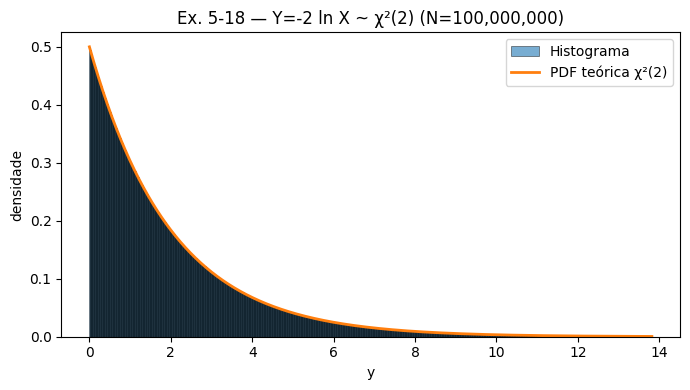

In [22]:
plt.figure(figsize=(7,4))
plt.hist(Y, bins=bin_edges, density=True,
         alpha=0.6, edgecolor="black", linewidth=0.5, label="Histograma")
plt.plot(ys, pdf, linewidth=2, label="PDF teórica χ²(2)")
plt.title(f"Ex. 5-18 — Y=-2 ln X ~ χ²(2) (N={N:,})")
plt.xlabel("y"); plt.ylabel("densidade")
plt.legend(); plt.tight_layout(); plt.show()

### Checagem dos momentos

Para $\chi^2(k)$, temos $\mathbb{E}[Y] = k$ e $\mathrm{Var}(Y) = 2k$.  
Para $k=2$, isso implica $\mathbb{E}[Y]=2$ e $\mathrm{Var}(Y)=4$.  
Comparamos os valores amostrais com esses teóricos.

In [23]:
mu_hat = Y.mean()
var_hat = Y.var()
print(f"Média amostral ≈ {mu_hat:.4f} | Teórica = 2")
print(f"Variância amostral ≈ {var_hat:.4f} | Teórica = 4")

Média amostral ≈ 2.0001 | Teórica = 2
Variância amostral ≈ 4.0006 | Teórica = 4


### Comentários (Ex. 5-18)

A transformação $Y = -2\ln X$, aplicada a $X \sim U(0,1)$, resultou em uma variável cuja distribuição empírica coincide com a qui-quadrado com dois graus de liberdade.  
A comparação entre o histograma e a p.d.f. teórica $f_Y(y)=\tfrac{1}{2}e^{-y/2}$ mostra um bom ajuste, sem discrepâncias visuais relevantes.

Os momentos amostrais também apresentaram boa concordância com os valores teóricos:
- Média amostral ≈ **2.0001** | Teórica = **2**  
- Variância amostral ≈ **4.0006** | Teórica = **4**

Esses resultados confirmam, tanto analiticamente quanto numericamente, que a transformação $Y = -2\ln X$ gera corretamente uma variável qui-quadrado com $2$ graus de liberdade, demonstrando a coerência entre a teoria da mudança de variável e a simulação Monte Carlo.